In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
from datetime import datetime
from itertools import cycle

In [21]:
# Konstanta dan konfigurasi
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
BASE_LEARNING_RATE = 1e-4
RANDOM_SEED = 42

In [22]:
# Set random seed untuk reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [23]:
# Path dataset
TRAIN_DIR = './FishImgDataset/train'
VAL_DIR = './FishImgDataset/val'
TEST_DIR = './FishImgDataset/test'

In [24]:
# Direktori untuk checkpoint dan logs
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_DIR = f"fish_model_{timestamp}"
LOG_DIR = os.path.join(MODEL_DIR, "logs")
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [25]:
def create_data_generators():
    """Membuat dan mengembalikan data generators untuk train, validasi, dan test."""
    
    # Data augmentation yang lebih dinamis untuk training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,          # Lebih agresif untuk rotasi
        zoom_range=0.15,            # Lebih bervariasi untuk zoom
        horizontal_flip=True,
        vertical_flip=True,         # Tambahan untuk ikan (karena bisa dilihat dari berbagai sudut)
        brightness_range=[0.85, 1.15],
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,            # Sedikit shear
        fill_mode='reflect'         # Mode fill yang berbeda, lebih alami untuk gambar alam
    )
    
    # Untuk validasi dan test, hanya rescaling
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    # Buat generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = valid_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = valid_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator

In [26]:
def build_improved_cnn_model(input_shape, num_classes):
    """
    Membangun model CNN yang ditingkatkan dengan residual connections
    dan arsitektur yang lebih dalam
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial block
    x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Block 1 dengan residual connection
    residual = x
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Residual connection
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Block 2 dengan residual connection
    residual = layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Residual connection
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Block 3 dengan residual connection
    residual = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])  # Residual connection
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.4)(x)
    
    # Global Average Pooling alih-alih Flatten (mengurangi parameter)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [27]:
def build_transfer_learning_model(input_shape, num_classes):
    """
    Membangun model dengan transfer learning menggunakan EfficientNetB0
    sebagai base model
    """
    # Load base model
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Buat model baru di atas base model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [28]:
def plot_sample_images(generator, class_names, rows=3, cols=3):
    """Plot sampel gambar dari generator."""
    plt.figure(figsize=(12, 12))
    
    # Ambil satu batch data
    for images, labels in generator:
        for i in range(min(rows * cols, len(images))):
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i])
            class_idx = np.argmax(labels[i])
            plt.title(class_names[class_idx])
            plt.axis("off")
        break  # Hanya ambil batch pertama
    
    plt.tight_layout()
    plt.show()

In [29]:
def plot_training_history(history):
    """Visualisasi history training model."""
    plt.figure(figsize=(14, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [30]:
def evaluate_model(model, test_generator):
    """Evaluasi model dan visualisasi hasilnya."""
    # Prediksi
    y_pred_probs = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    
    # Hitung metrik evaluasi
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    try:
        roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
    except:
        roc_auc = 0
        print("Couldn't compute ROC AUC score properly, defaulting to zero.")
    
    # Print metrik
    print("\n===== Model Evaluation =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, test_generator.class_indices)
    
    # Plot ROC curve jika jumlah kelas cukup kecil
    if len(test_generator.class_indices) <= 10:
        plot_roc_curve(y_true, y_pred_probs, test_generator.class_indices)
    else:
        print(f"Skipping ROC curve plot as there are too many classes ({len(test_generator.class_indices)})")
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

In [31]:
def plot_confusion_matrix(y_true, y_pred, class_indices):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    # Reverse class_indices untuk mendapatkan label
    labels = {v: k for k, v in class_indices.items()}
    class_labels = [labels[i] for i in range(len(labels))]
    
    # Plot dengan seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, 
        annot=True if len(class_indices) <= 15 else False,  # Tampilkan angka jika kelas tidak terlalu banyak
        fmt='d', 
        cmap='Blues',
        xticklabels=class_labels if len(class_indices) <= 15 else [],
        yticklabels=class_labels if len(class_indices) <= 15 else []
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [32]:
def plot_roc_curve(y_true, y_pred_probs, class_indices):
    """Plot ROC curve untuk multi-class."""
    n_classes = len(class_indices)
    
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Reverse class_indices untuk mendapatkan label
    labels = {v: k for k, v in class_indices.items()}
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # Sebagai sampel, tampilkan hanya 5 kelas teratas berdasarkan AUC jika terlalu banyak kelas
    if n_classes > 5:
        top_classes = sorted([(i, roc_auc[i]) for i in range(n_classes)], key=lambda x: x[1], reverse=True)[:5]
        class_indices_to_plot = [i for i, _ in top_classes]
    else:
        class_indices_to_plot = range(n_classes)
    
    colors = cycle(plt.cm.tab10.colors)
    for i, color in zip(class_indices_to_plot, colors):
        plt.plot(
            fpr[i], tpr[i], color=color, lw=2,
            label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})'
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [33]:
def main():
    """Fungsi utama."""
    # Siapkan data generators
    train_generator, val_generator, test_generator = create_data_generators()
    
    # Dapatkan jumlah kelas
    num_classes = len(train_generator.class_indices)
    print(f"Jumlah kelas ikan: {num_classes}")
    print("Nama kelas ikan:", list(train_generator.class_indices.keys()))
    
    # Plot sampel gambar
    class_names = list(train_generator.class_indices.keys())
    plot_sample_images(train_generator, class_names)
    
    # Building models
    input_shape = IMAGE_SIZE + (3,)  # (height, width, channels)
    
    print("\n===== Membuat Model CNN yang Ditingkatkan =====")
    cnn_model = build_improved_cnn_model(input_shape, num_classes)
    cnn_model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(MODEL_DIR, 'fish_classifier_best.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        TensorBoard(log_dir=LOG_DIR)
    ]
    
    # Compile model
    cnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Training
    print("\n===== Training Model =====")
    history = cnn_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluasi model
    print("\n===== Evaluasi Model pada Test Set =====")
    metrics = evaluate_model(cnn_model, test_generator)
    
    # Simpan model
    cnn_model.save(os.path.join(MODEL_DIR, 'fish_classifier_final.h5'))
    print(f"\nModel disimpan di {MODEL_DIR}")
    
    return cnn_model, metrics

In [34]:
# Optional: Transfer Learning Model
def train_transfer_learning_model():
    """
    Fungsi untuk melatih model transfer learning sebagai alternatif.
    Dapat dijalankan terpisah atau sebagai perbandingan.
    """
    train_generator, val_generator, test_generator = create_data_generators()
    num_classes = len(train_generator.class_indices)
    input_shape = IMAGE_SIZE + (3,)
    
    print("\n===== Membuat Model Transfer Learning dengan EfficientNet =====")
    tl_model = build_transfer_learning_model(input_shape, num_classes)
    tl_model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
        ModelCheckpoint(
            filepath=os.path.join(MODEL_DIR, 'fish_tl_model_best.h5'),
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
    
    # Compile model
    tl_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Training - fase awal dengan base model dibekukan
    print("\n===== Training Model Transfer Learning (Phase 1) =====")
    history1 = tl_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        callbacks=callbacks
    )
    
    # Unfreeze beberapa layer terakhir dari base model untuk fine-tuning
    base_model = tl_model.layers[0]
    base_model.trainable = True
    
    # Bekukan semua kecuali 30 layer terakhir dari base model
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    
    # Compile ulang dengan learning rate yang lebih kecil
    tl_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Training - fase fine-tuning
    print("\n===== Fine-tuning Model Transfer Learning (Phase 2) =====")
    history2 = tl_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        callbacks=callbacks
    )
    
    # Evaluasi model
    print("\n===== Evaluasi Model Transfer Learning pada Test Set =====")
    metrics = evaluate_model(tl_model, test_generator)
    
    # Simpan model
    tl_model.save(os.path.join(MODEL_DIR, 'fish_tl_model_final.h5'))
    
    # Gabungkan history untuk plotting
    combined_history = {}
    for key in history1.history:
        combined_history[key] = history1.history[key] + history2.history[key]
    
    # Plot
    plot_training_history(keras.callbacks.History().set_params({'history': combined_history}))
    
    return tl_model, metrics

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Jumlah kelas ikan: 31
Nama kelas ikan: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


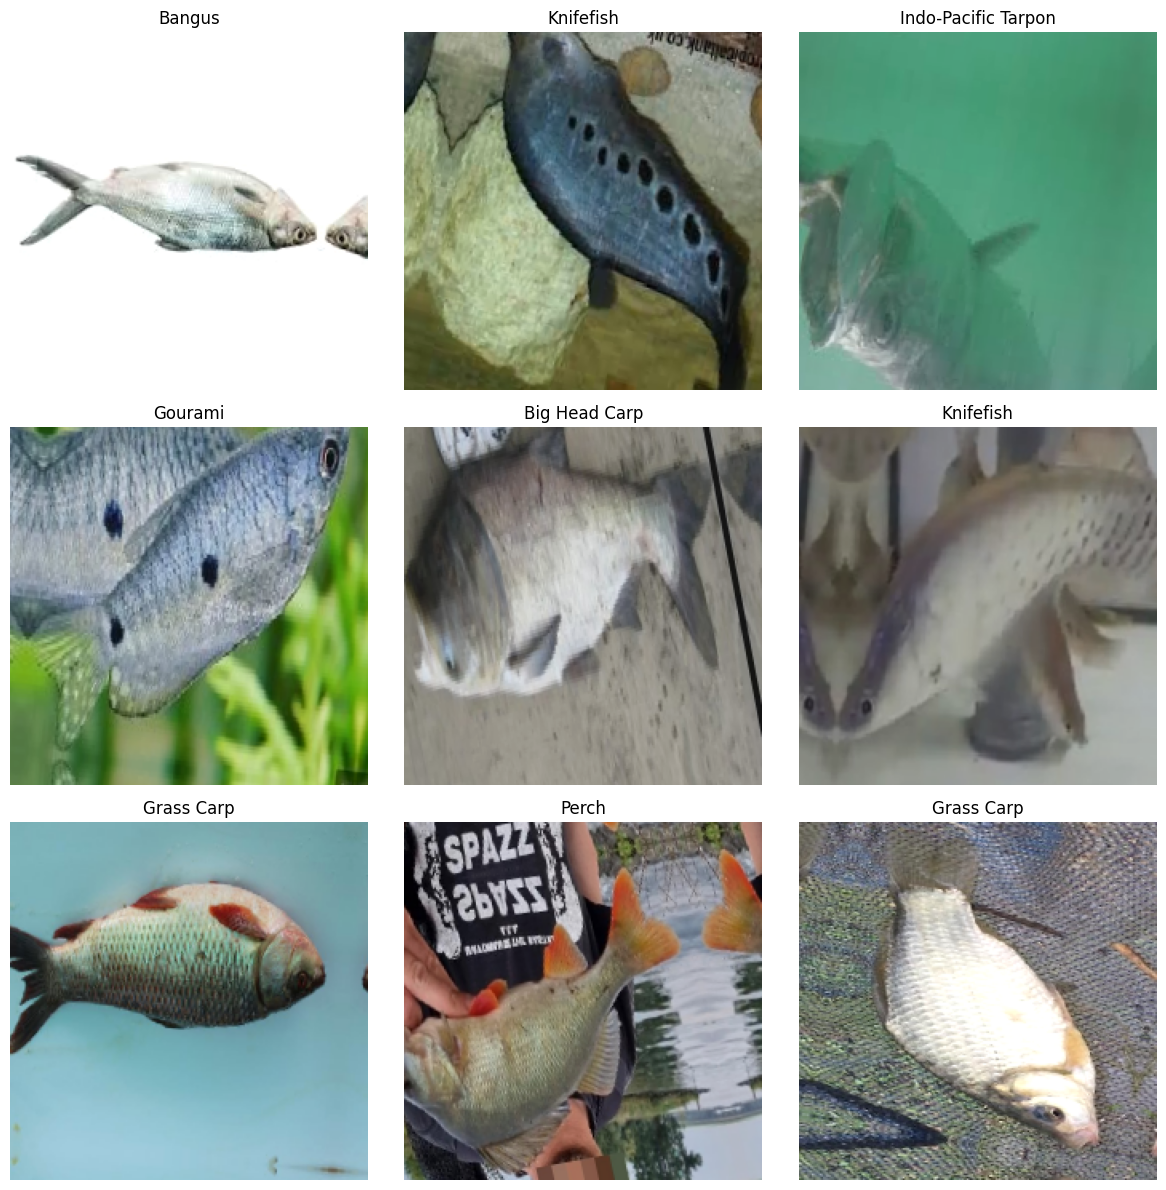


===== Membuat Model CNN yang Ditingkatkan =====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 112, 112,  │          0 │ activation_16[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 112, 112,  │     36,928 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_17[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ add_6[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ activation_18[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 56, 56,    │     73,856 │ dropout_8[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 1,377,055 (5.25 MB)

 Trainable params: 1,374,111 (5.24 MB)

 Non-trainable params: 2,944 (11.50 KB)


===== Training Model =====
Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1194 - loss: 3.5553
Epoch 1: val_accuracy improved from -inf to 0.09851, saving model to fish_model_20250503-185433\fish_classifier_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 1471s 5s/step - accuracy: 0.1196 - loss: 3.5545 - val_accuracy: 0.0985 - val_loss: 4.5400 - learning_rate: 1.0000e-04
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2178 - loss: 3.0267
Epoch 2: val_accuracy improved from 0.09851 to 0.20865, saving model to fish_model_20250503-185433\fish_classifier_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 1401s 5s/step - accuracy: 0.2179 - loss: 3.0265 - val_accuracy: 0.2087 - val_loss: 3.2770 - learning_rate: 1.0000e-04
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2484 - loss: 2.8360
Epoch 3: val_accuracy improved from 0.20865 to 0.26390, saving model to fish_model_20250503-185433\fish_classifier_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 1361s 5s/step - accuracy: 0.2484 - loss: 2.8359 - val_accuracy: 0.2639 - val_loss: 2.7688 - learning_rate: 1.0000e-04
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2812 - loss: 2.6549
Epoch 4: val_accuracy improved from 0.26390 to 0.27808, saving model to fish_model_20250503-185433\fish_classifier_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 1382s 5s/step - accuracy: 0.2812 - loss: 2.6549 - val_accuracy: 0.2781 - val_loss: 2.6588 - learning_rate: 1.0000e-04
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3093 - loss: 2.5424
Epoch 5: val_accuracy improved from 0.27808 to 0.31552, saving model to fish_model_20250503-185433\fish_classifier_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 1490s 5s/step - accuracy: 0.3093 - loss: 2.5423 - val_accuracy: 0.3155 - val_loss: 2.4492 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 5.


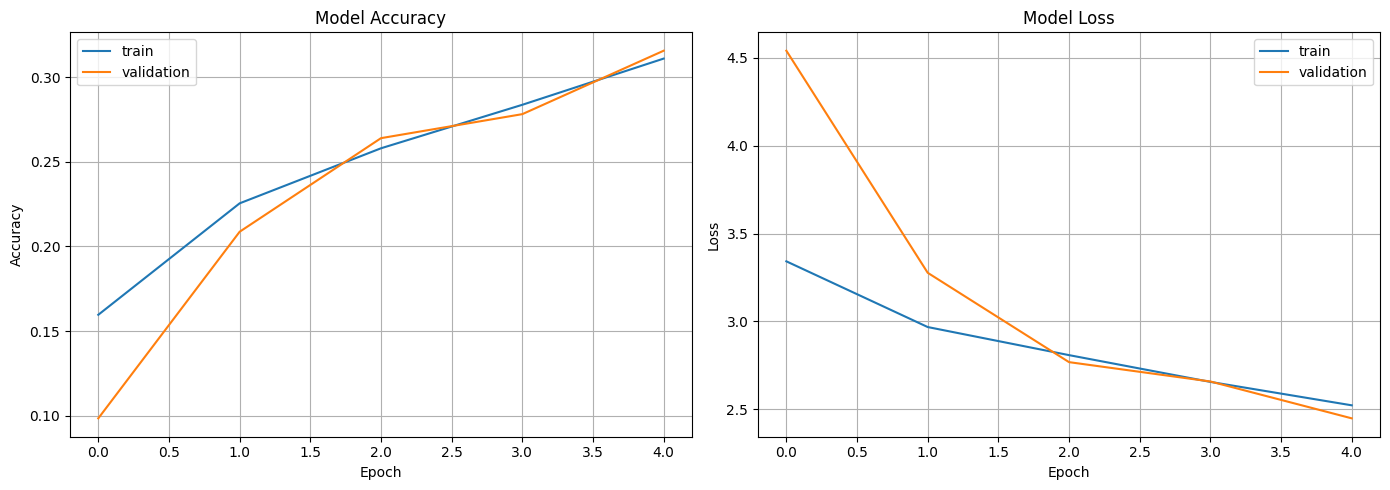


===== Evaluasi Model pada Test Set =====
55/55 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step


c:\Users\Azka\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



===== Model Evaluation =====
Accuracy: 0.3392
Precision: 0.2895
Recall: 0.3392
F1 Score: 0.2790
ROC AUC Score: 0.8647


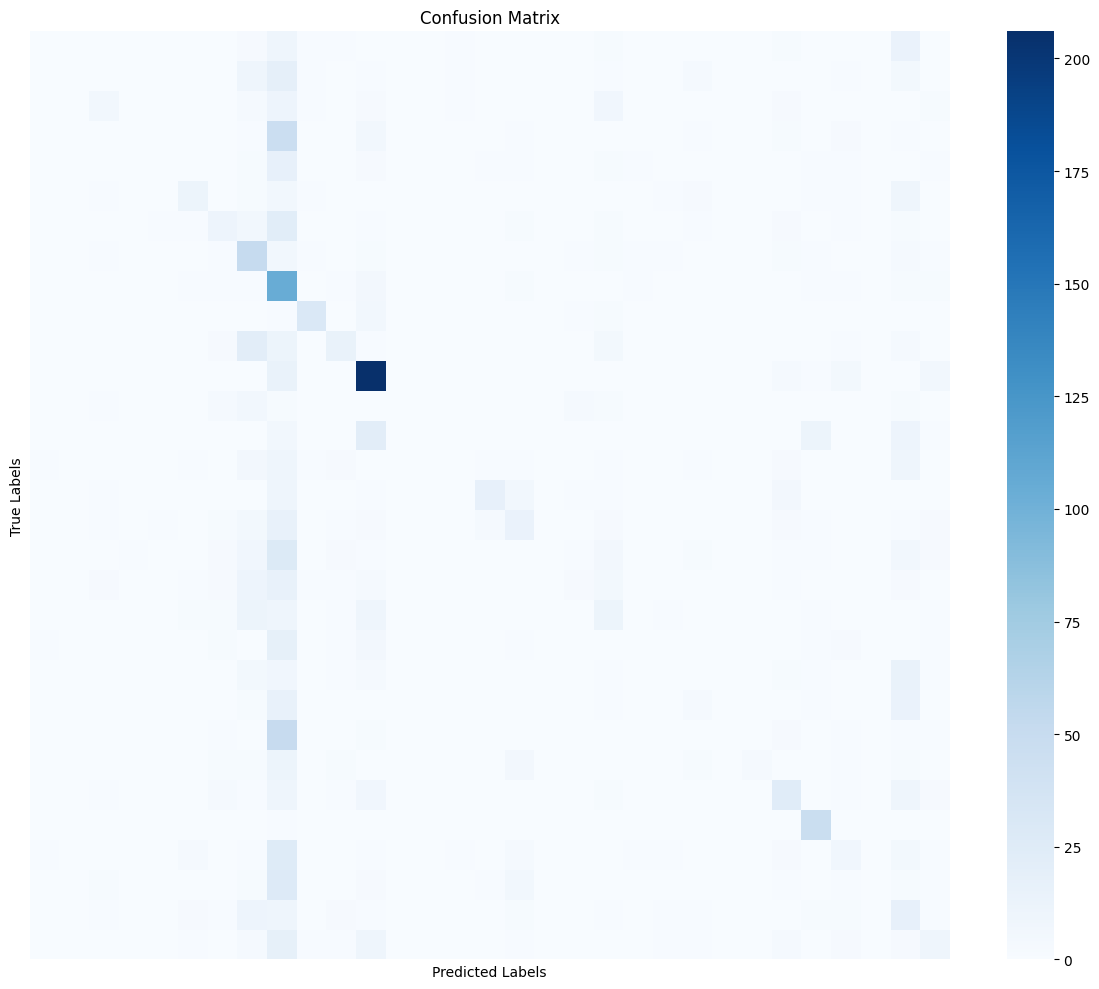

Skipping ROC curve plot as there are too many classes (31)

Model disimpan di fish_model_20250503-185433


In [35]:
if __name__ == "__main__":
    cnn_model, cnn_metrics = main()

## Matriks Evaluasi Klasifikasi (Accuracy, Precision, Recall, F1-Score, AUC-ROC)
Akurasi model yang hanya 33.92% disebabkan oleh jumlah epoch yang sangat rendah, hanya 5 epoch. Dengan epoch yang sedikit, model belum cukup waktu untuk belajar dan mengoptimalkan parameter, sehingga menghasilkan performa yang kurang maksimal. Meningkatkan jumlah epoch dapat membantu model belajar lebih baik dan meningkatkan akurasi.